In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
sns.set_theme(style='ticks', context='notebook', font_scale=1.1)

## Section 1: Behavior

In [2]:
## Iteratively load data.
data = []
for session in ['s1','s2','s3','s4']:
    
    ## Load data.
    df = read_csv(os.path.join('data', session, 'pgng.csv'))

    ## Restrict participants.
    if session == 's1':
        reject = read_csv(os.path.join('data', session, 'reject.csv'))
        df = df[df.subject.isin(reject.query('reject==0').subject)].reset_index(drop=True)
        
    ## Append.
    data.append(df)
    
## Concatenate DataFrames.
data = concat(data)

## Return number of participants per session.
print(data.groupby('session').subject.nunique())

session
1    103
2     96
3     93
4     91
Name: subject, dtype: int64


### 1.1 Learning curves

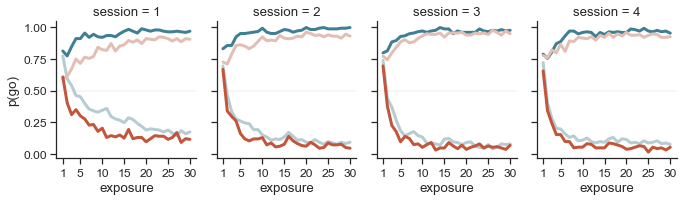

In [3]:
## Initialize canvas.
g = sns.FacetGrid(data, col='session', col_order=[1,2,3,4], aspect=0.8)

## Define aesthetics.
palette = sns.diverging_palette(220, 20, n=4)
hue_order = ['gw','ngw','gal','ngal']

## Plot learning curves.
g.map(sns.lineplot, 'exposure', 'choice', 'robot', hue_order=hue_order, palette=palette, lw=3, ci=None)

## Add trend line.
for ax in g.axes.flatten(): ax.axhline(0.5, color='k', alpha=0.05, zorder=-1)

## Adjust x-axis.
g.set(xticks=np.append(1, np.arange(5,31,5)))
g.set_xlabels('exposure')

## Adjust y-axis.
g.set_ylabels('p(go)');

In [4]:
from statsmodels.api import Logit

## Define formula.
formula = 'choice ~ valence'

## Iterate over sessions.
results = []
for s in [1,2,3,4]:
    
    ## Fit logistic regression model.
    fit = Logit.from_formula(formula, data=data.query(f'session == {s} and exposure == 1')).fit(disp=0);
    
    ## Extract & append results table.
    fit = fit.summary2().tables[-1]
    fit.insert(0, 'session', s)
    results.append(fit)
    
## Concatenate DataFrame.
results = concat(results).reset_index().sort_values(['index','session']).set_index(['index','session'])
results.round(3)

Coef.  Std.Err.      z  P>|z|  [0.025  0.975]
index          session                                               
Intercept      1        0.403     0.101  4.013  0.000   0.206   0.601
               2        0.825     0.111  7.442  0.000   0.608   1.042
               3        1.001     0.117  8.556  0.000   0.771   1.230
               4        0.916     0.116  7.897  0.000   0.689   1.144
valence[T.win] 1        0.929     0.157  5.899  0.000   0.620   1.238
               2        0.330     0.163  2.023  0.043   0.010   0.649
               3        0.186     0.169  1.098  0.272  -0.146   0.518
               4        0.197     0.168  1.173  0.241  -0.132   0.526

### 1.2 Individual-differences

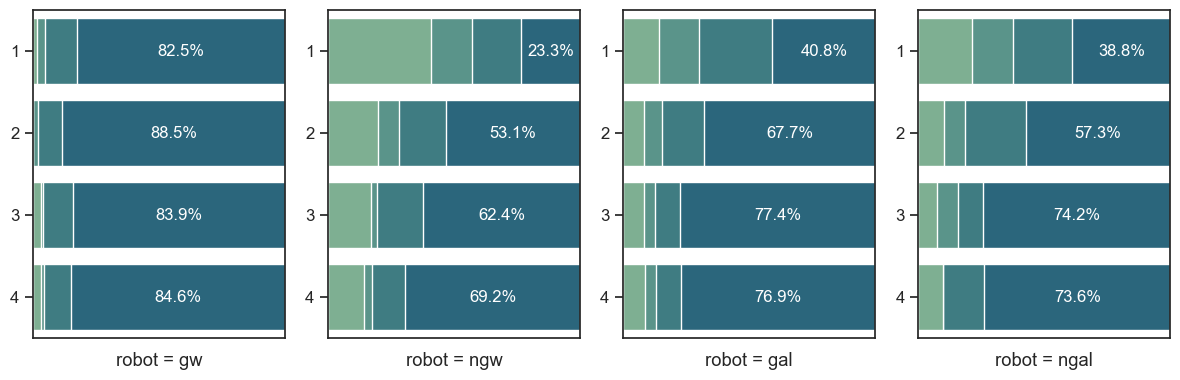

In [5]:
## Compute accuracy by participant / session / condition.
gb = data.groupby(['subject','session','robot']).accuracy.mean().reset_index()

## Score performance into top five deciles.
gb['score'] = np.digitize(gb.accuracy, np.arange(0.6,1.0,0.1))

## Calculate proportion of participants in each bin.
gb = gb.pivot_table('subject', 'score', ['robot','session'], aggfunc='count').fillna(0)
gb = gb.apply(lambda x: np.cumsum(x / x.sum()))

## Initialize canvas.
fig, axes = plt.subplots(1, 4, figsize=(12,4), sharex=True)
palette = sns.color_palette('crest_r', n_colors=5).as_hex()

## Iteratively plot.
for ax, robot in zip(axes, ['gw','ngw','gal','ngal']):

    ## Iteratively stack bars.
    for i, color in enumerate(palette):
        sns.barplot(x=gb.iloc[-i][robot].values, y=gb[robot].columns, order=[1,2,3,4],
                    color=color, orient='h', ax=ax)
                
    ## Adjust x-axis.
    ax.set(xlim=(0,1), xticks=[], xlabel=f'robot = {robot}')
    
    ## Adjust y-axis.
    ax.set(ylabel='', yticks=[0,1,2,3], yticklabels=[1,2,3,4])
    
    ## Add annotation.
    props = gb[robot].diff().iloc[-1].values
    for i, p in enumerate(props): ax.annotate('%0.1f%%' %(p * 100), (0,0), (1 - p/2, i),
                                              va='center', ha='center', color='w', fontsize=12)

## Adjust spines.
# sns.despine(left=True, right=True, top=True, bottom=True)
plt.tight_layout()